In [1]:
%load_ext autoreload
%autoreload 2


# $\beta$-VAE [4]

One of the priors of representation learning, a domain where VAEs are widely applied, is the disentanglement of features [5] - meaning single latent units are sensitive to changes in single generative factors, while being relatively invariant to changes in other factors.

To give an example: a disentangled representation of face images would lead to having independent latent units sensitive to one characteristic of a face: one sensitive to its size, one to the color, one width, one length etc., with no interference between each other. An entangled representation would mean, that varying one latent unit will influence several characteristics of the output image.

As you could see during the analysis of a VAE model in previous notebook, a vanilla VAE cannot provide a good, distentangled representation of input. Most of the features cannot be easily interpreted, and changing their values usually modifies more than one factors of the output data.

Higgins et al. in [4] proposed a modified approach to variational autoencoder framework. To ensure, that the inferred latent factors $q_\phi\left(\mathbf{z}\vert\mathbf{x}\right)$ capture the generative factors in a disentangled manner, they introduce a constraint over it by trying to match to a prior $p\left(\mathbf{z}\right)$ that can control the capacity of the latent information bottleneck. This is achieved by modifying approximate posterior regularization term in ELBO inequality with a regularisation coefficient $\beta$.

$$\log p_\theta \left(\mathbf{x}\right) \ge  \mathcal{L}\left(\mathbf{x}, \theta, \phi, \beta\right) = \underbrace{\mathbb{E}_{\mathbf{z}}\left[\log p_\theta\left(\mathbf{x}\vert\mathbf{z}\right)\right]}_{\text{reconstruction term}} - \overbrace{\beta}^{\text{regularization coefficient}}\underbrace{\left(D_{KL}\left(q_\phi\left(\mathbf{z}\vert\mathbf{x}\right)\| p\left(\mathbf{z}\right)\right)\right)}_{\text{approximate posterior regularization}}$$

Varying $\beta$ changes the degree of applied learning pressure during training, encouraging different representations. $\beta=1$ corresponds to original VAE formulation, discussed in the previous notebook. The authors postulate, that setting $\beta>1$ encourages the model to learn disentangled representations of the conditionally independent data generative factors by putting a stronger constraint on the latent bottleneck than in the original VAE formulation. This constraint limits the capacity of $\mathbf{z}$ and hence should encourage the model to learn the most efficient representation of the data. Authors show, that higher $\beta$ encourages learning a disentangled representation, however there is a trade-off between reconstruction fidelity and the quality of disentanglement. That is what we will be seeing in this exercise: when analysing latent features' values we should see multiple rows, where varying feature's value does not change the reconstruction. By increasing $\beta$, the number of "deactivated" features should rise.

> [[4] Higgins, I., Matthey, L., Pal, A., Burgess, C., Glorot, X., Botvinick, M., Mohamed, S., Lerchner, A., *β-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework*. 2017.](https://openreview.net/references/pdf?id=Sy2fzU9gl)

> [[5] Bengio, Y., Courville, A., Vincent, P., *Representation Learning: A Review and New Perspectives*. 2012.](https://arxiv.org/pdf/1206.5538.pdf)


## Implementing $\beta$-VAE

Once again, we will be using MNIST dataset (same as before).

In this task our aim is to modify the VAE by providing the ability to tune the regularization coefficient and to train the model to perform a similar analysis as before.

In `src/b_vae.py` implement the `BetaVariationalAutoEncoder` class, which will reuse as much of the implementation details from `VariationalAutoEncoder`.

> Tip: look for an appropriate effect handler in [`pyro.poutine`](http://docs.pyro.ai/en/stable/poutine.html).

Then, use the class to train a model and research the hyperparameter `beta` and its influence on the results of the analysis.


### Loading data


In [2]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

np.random.seed(0)


In [3]:
train_dataset = MNIST(
    root="data",
    download=True,
    train=True,
    transform=ToTensor()  # converts numpy form to torch tensor in range [0, 1]
)
test_dataset = MNIST(
    root="data",
    download=True,
    train=False,
    transform=ToTensor()
)

# limiting the dataset
indices = np.random.permutation(len(train_dataset.data))[:10_000]
train_dataset.data = train_dataset.data[indices]
train_dataset.targets = train_dataset.targets[indices]


In [4]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=False
)


### Preparing and training the model

Here we instantiate our model with an additional `beta` parameter and proceed to train it.


In [5]:
# you have to fill the implementation in the source file
from src.b_vae import BetaVariationalAutoEncoder


model = BetaVariationalAutoEncoder(
    n_data_features=28 * 28,  # MNIST pixels
    n_encoder_hidden_features=128,  # chosen arbitrarily
    n_decoder_hidden_features=128,  # chosen arbitrarily
    n_latent_features=20,  # how many features will be used to represent input
    beta=3.  # should limit the number of valuable features
)


In [6]:
from src.utils import train_vae

from pyro.infer import Trace_ELBO


epochs = 20
LR = 1e-3

loss_fn = Trace_ELBO()

train_metrics, test_metrics = train_vae(
    model=model,
    epochs=epochs,
    train_loader=train_loader,
    test_loader=test_loader,
    lr=LR,
    loss_fn=loss_fn
)


Epoch: 1 / 20.



Epoch: 2 / 20.



Epoch: 3 / 20.



Epoch: 4 / 20.



Epoch: 5 / 20.



Epoch: 6 / 20.



Epoch: 7 / 20.



Epoch: 8 / 20.



Epoch: 9 / 20.



Epoch: 10 / 20.



Epoch: 11 / 20.



Epoch: 12 / 20.



Epoch: 13 / 20.



Epoch: 14 / 20.



Epoch: 15 / 20.



Epoch: 16 / 20.



Epoch: 17 / 20.



Epoch: 18 / 20.



Epoch: 19 / 20.



Epoch: 20 / 20.


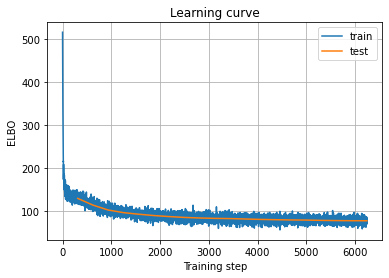

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(
    train_metrics["step"],
    train_metrics["loss"],
    label="train"
)
ax.plot(
    test_metrics["step"],
    test_metrics["loss"],
    label="test"
)
ax.set_xlabel("Training step")
ax.set_ylabel("ELBO")
ax.set_title("Learning curve")
ax.legend()
ax.grid()
plt.show()


### Reconstruction analysis

In the analysis part notice how the results are different from the vanilla VAE, and how `beta` changes the latent space.


In [8]:
from src.utils import AutoEncoderAnalyzer
import matplotlib.pyplot as plt


In [9]:
analyzer = AutoEncoderAnalyzer(
    model=model,
    dataset=test_dataset,
    n_samplings=5
)

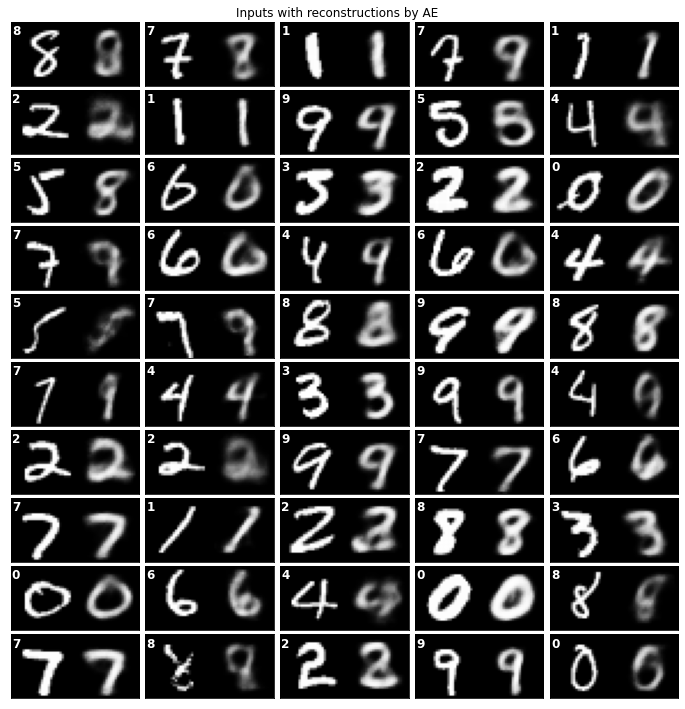

In [10]:
analyzer.compare_reconstruction_with_original()
plt.show()


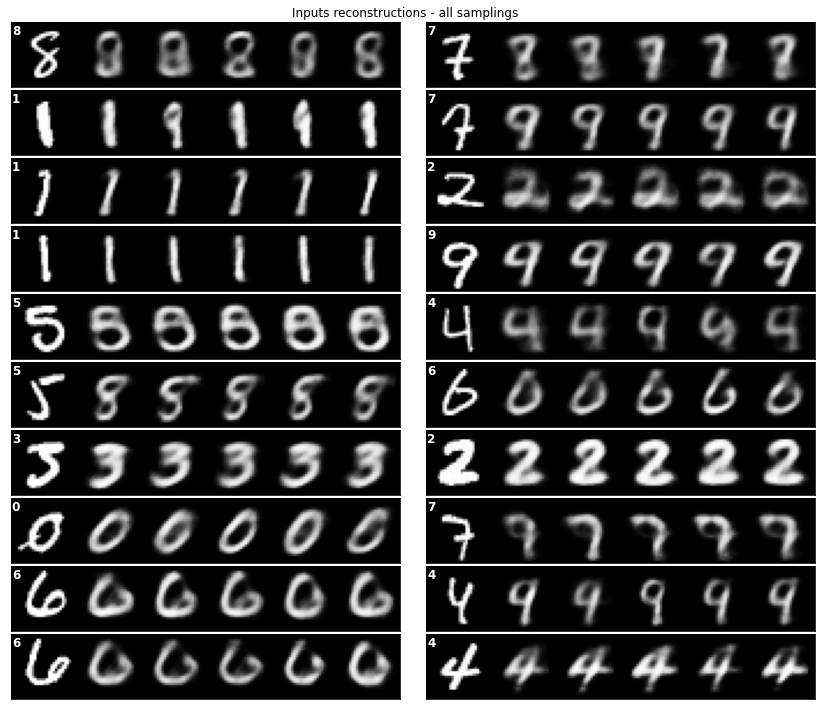

In [11]:
analyzer.compare_samplings()
plt.show()


### Generative capabilities

Focus on how latent vector's units become inactive with appropriate value of `beta`.


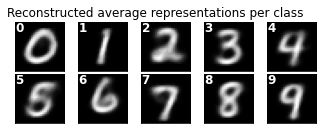

In [12]:
analyzer.average_points_per_class()
plt.show()


Digit: 0
Researching values in range [-9.0, 9.0]


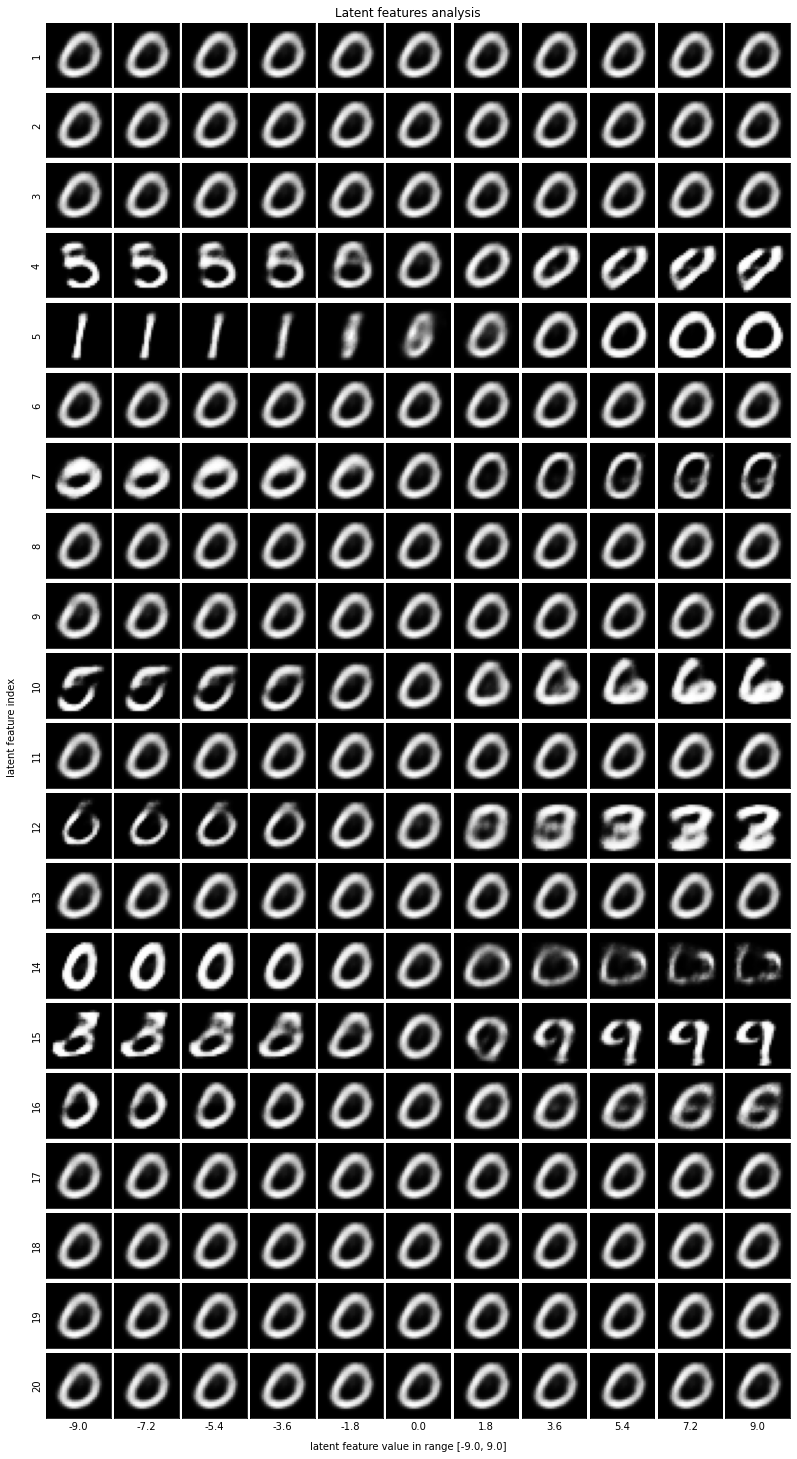

Digit: 1
Researching values in range [-9.0, 9.0]


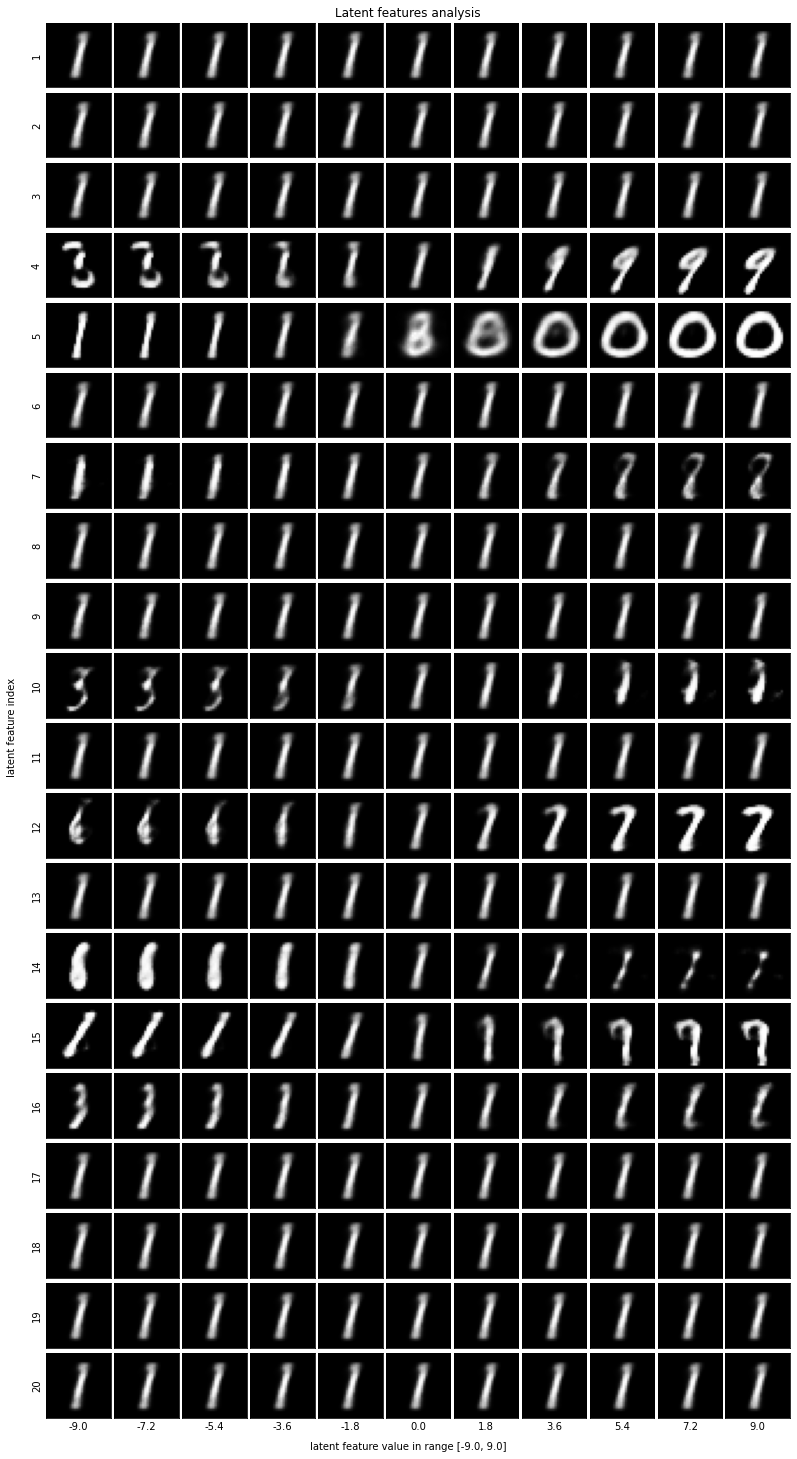

Digit: 2
Researching values in range [-9.0, 9.0]


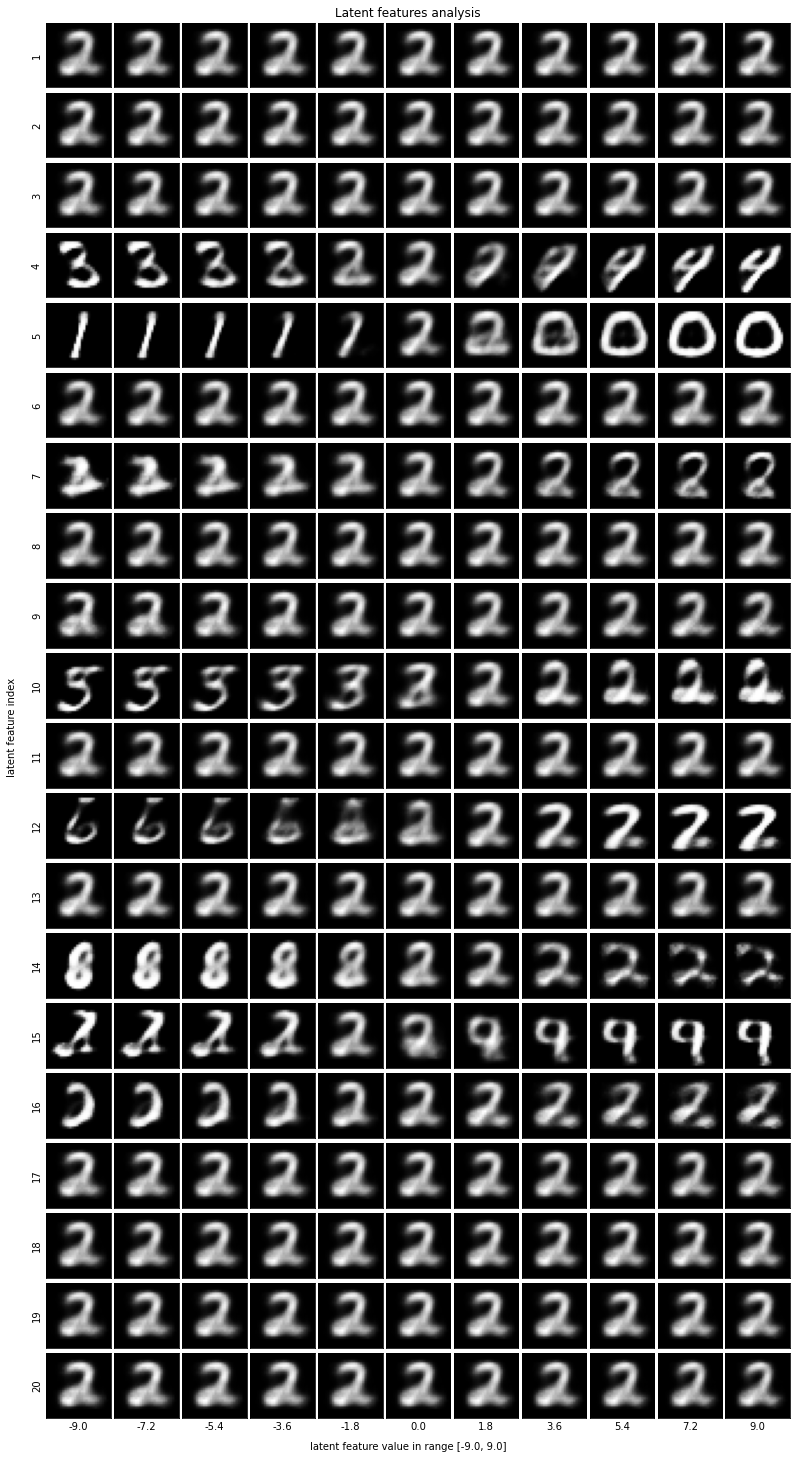

Digit: 3
Researching values in range [-9.0, 9.0]


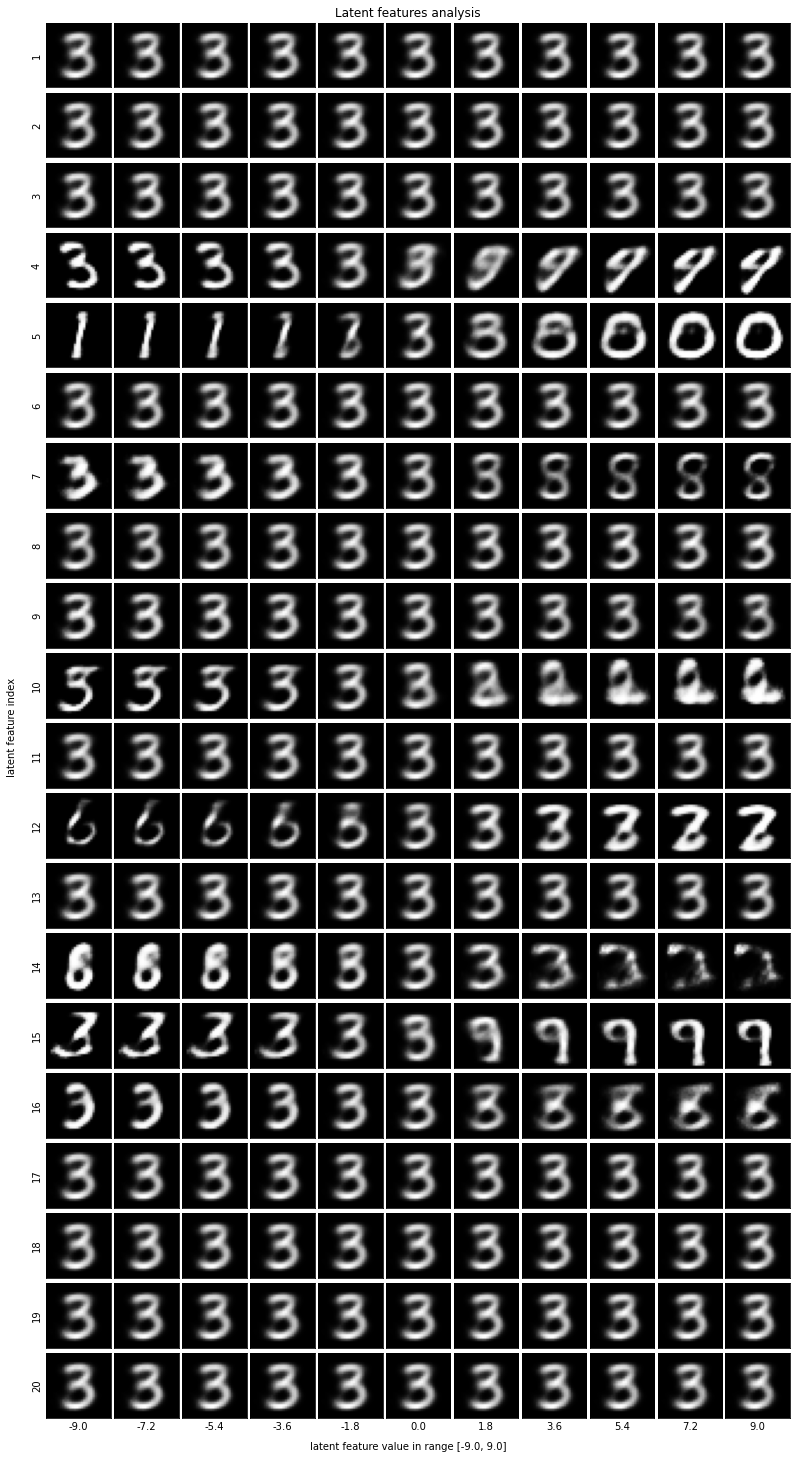

Digit: 4
Researching values in range [-9.0, 9.0]


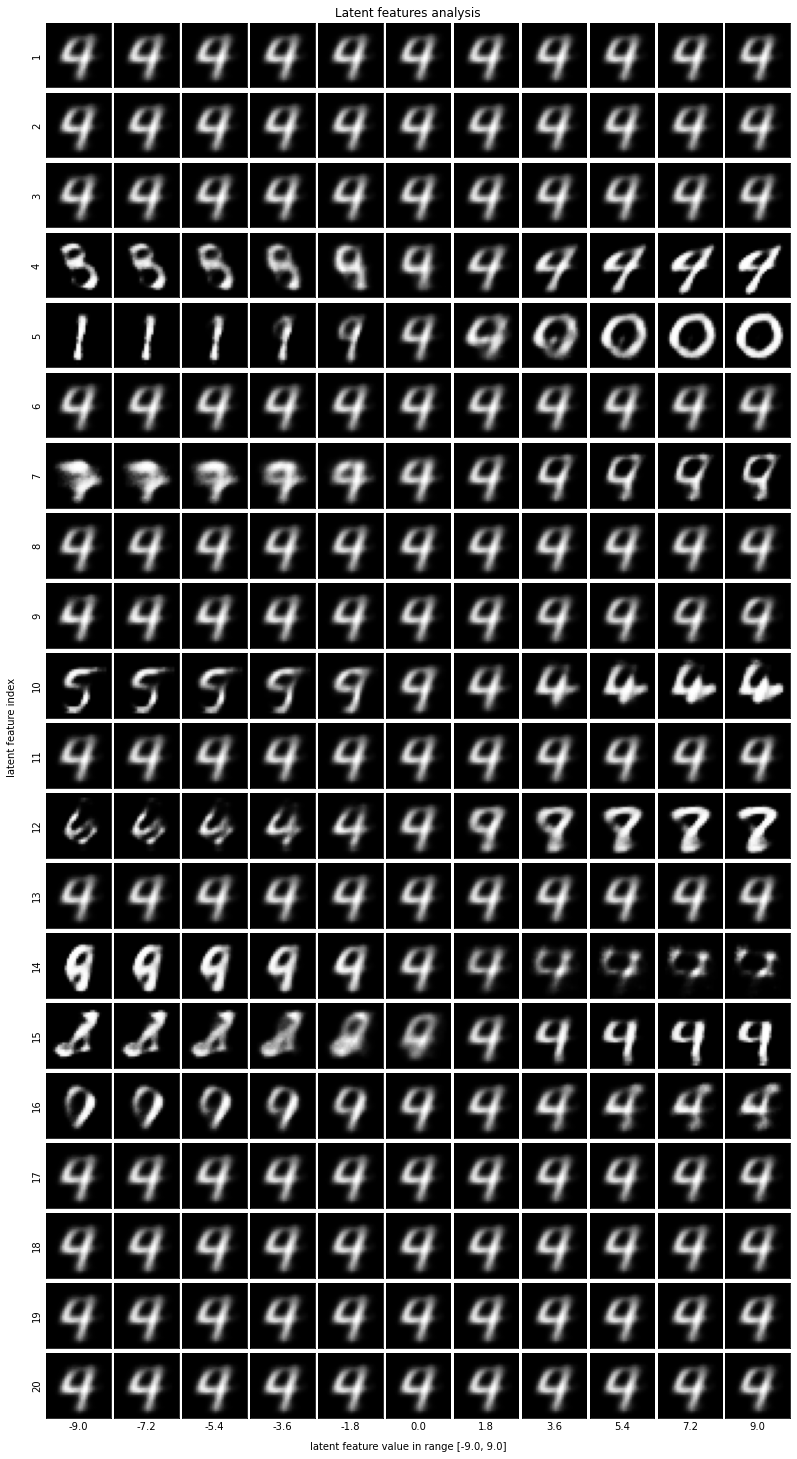

Digit: 5
Researching values in range [-9.0, 9.0]


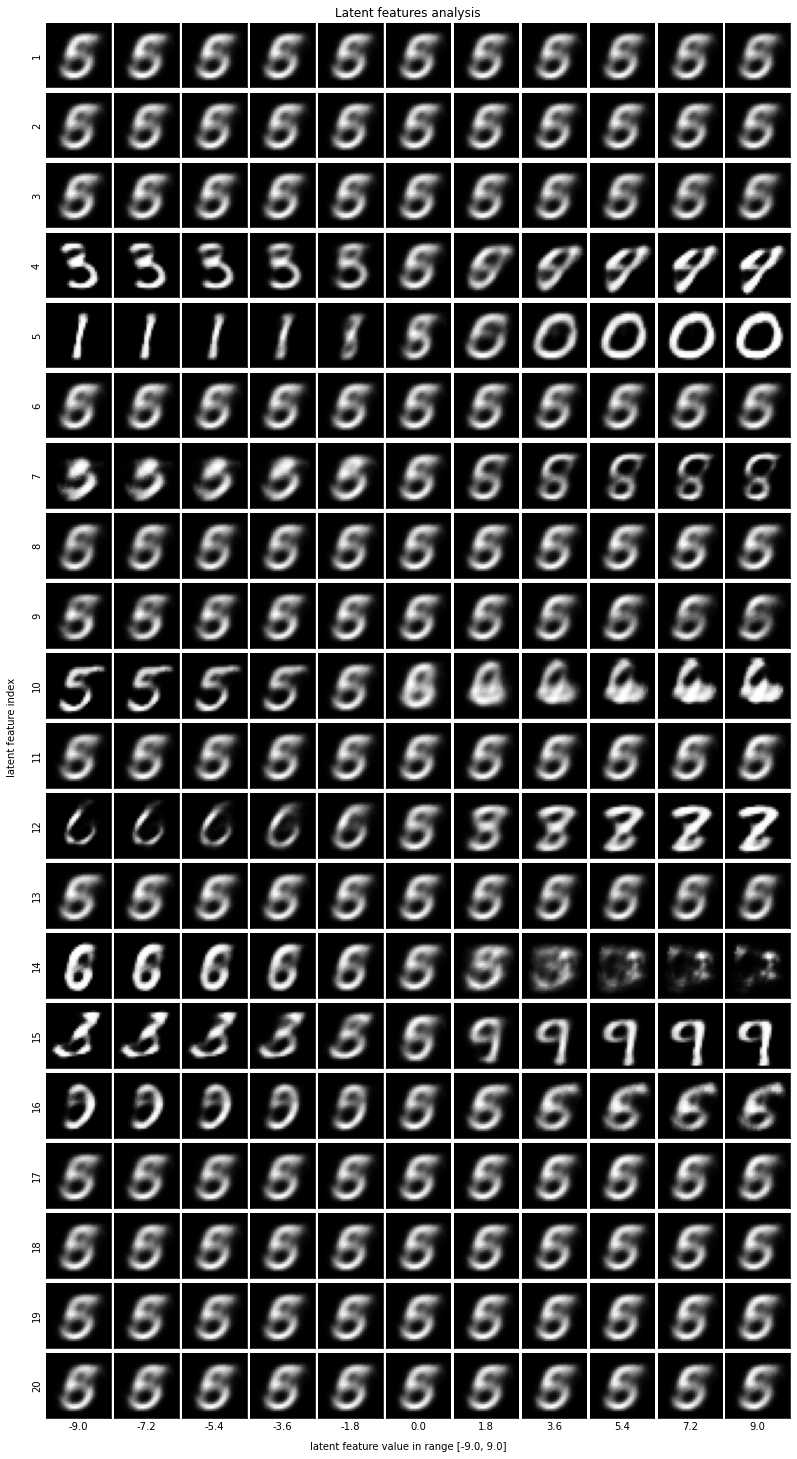

Digit: 6
Researching values in range [-9.0, 9.0]


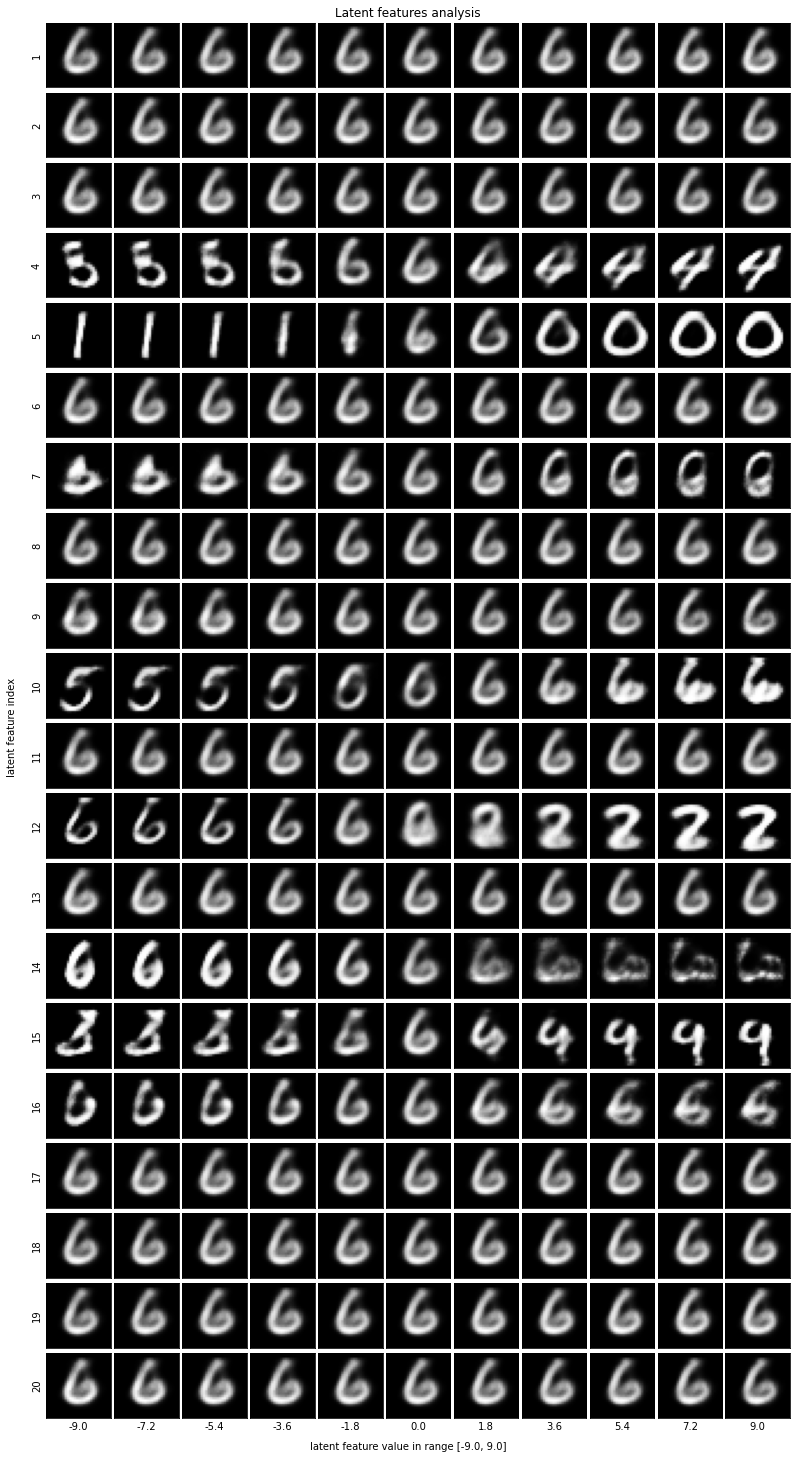

Digit: 7
Researching values in range [-9.0, 9.0]


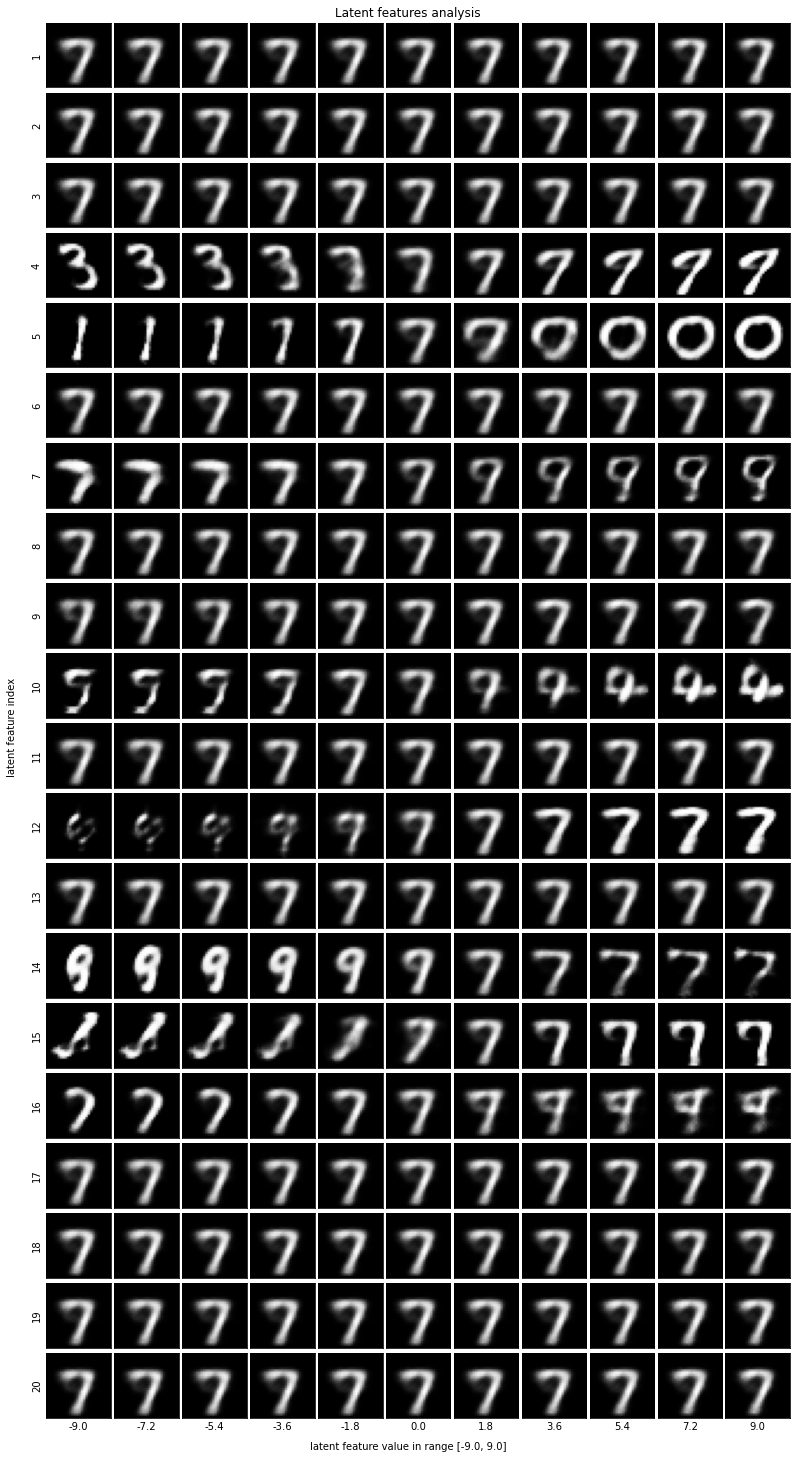

Digit: 8
Researching values in range [-9.0, 9.0]


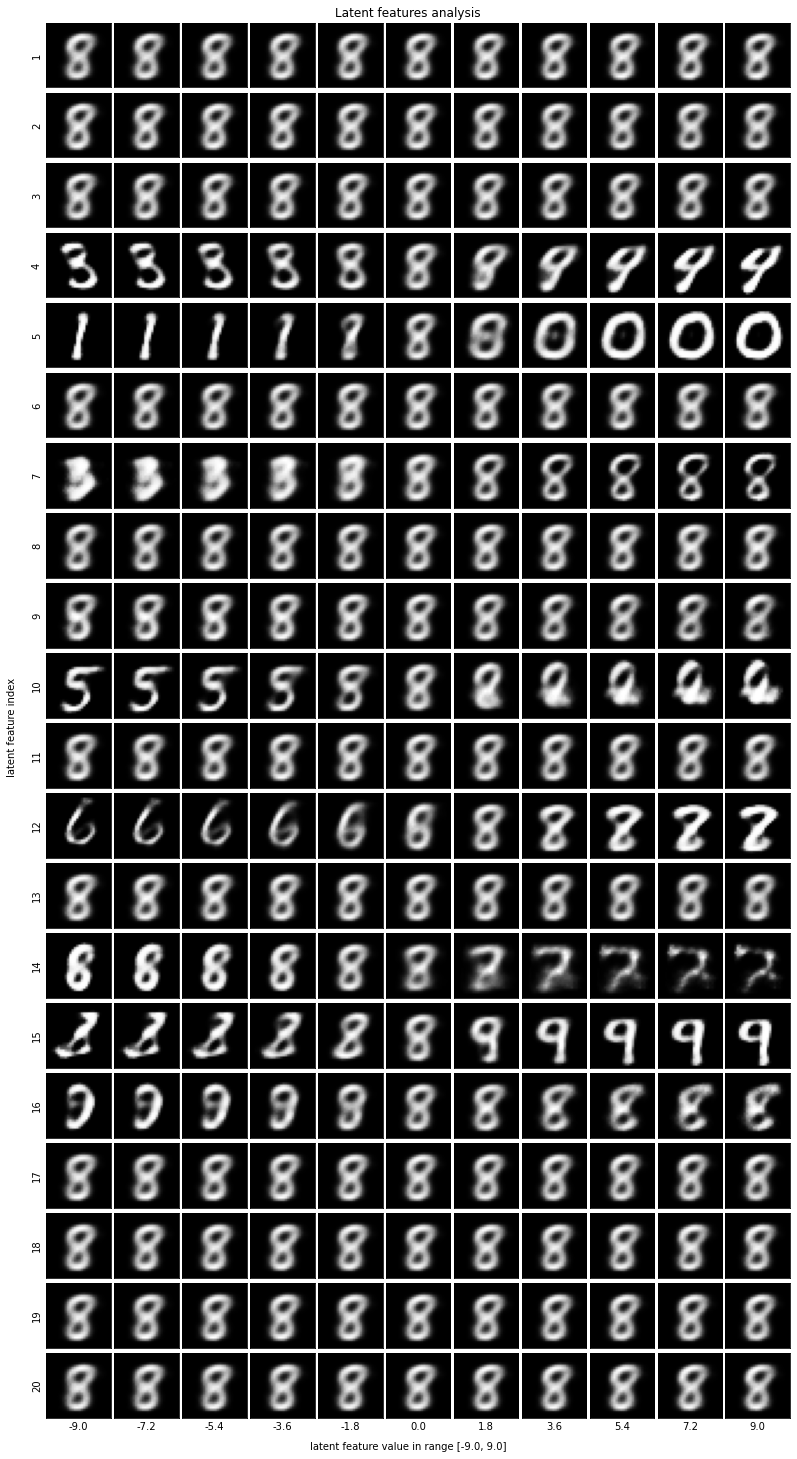

Digit: 9
Researching values in range [-9.0, 9.0]


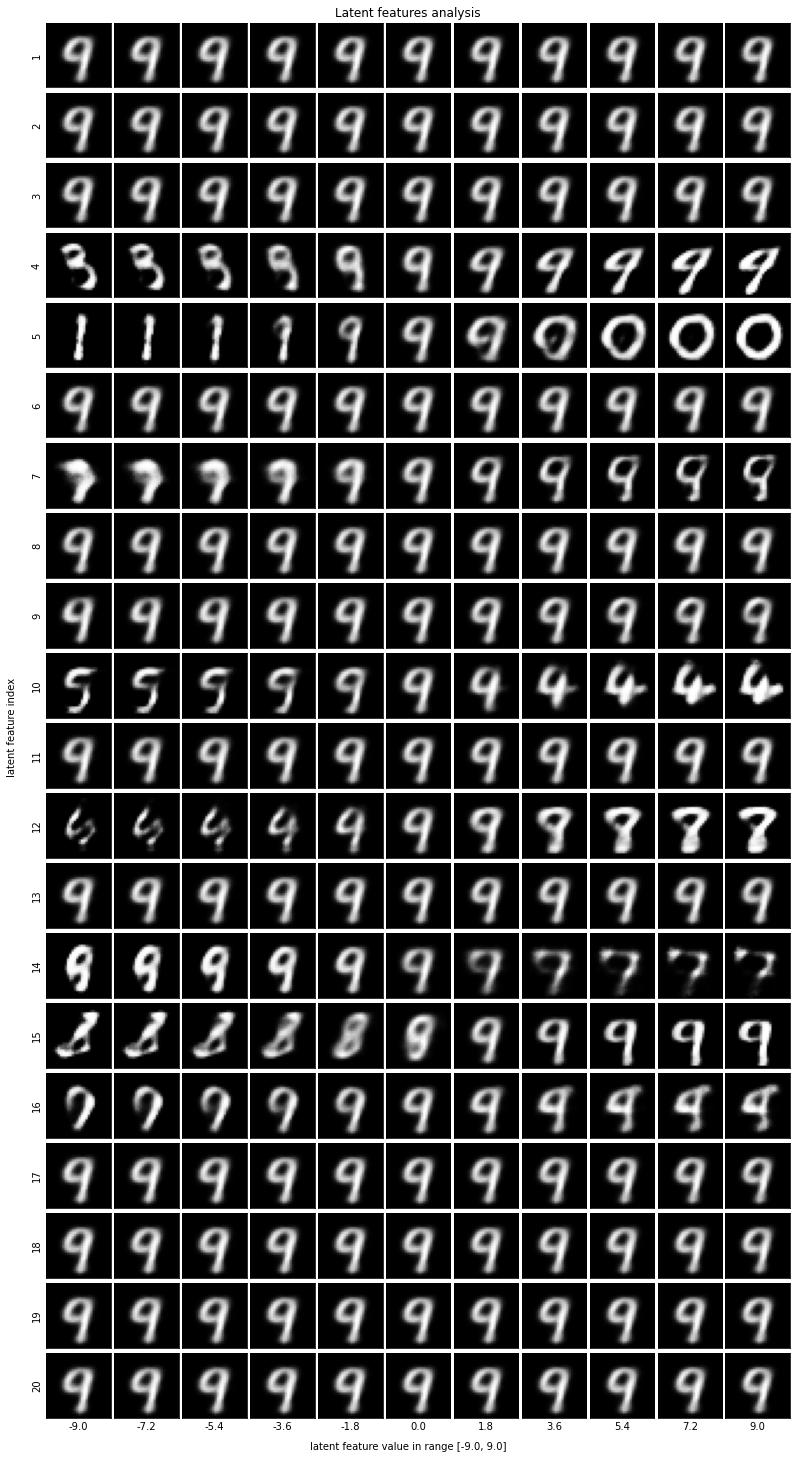

In [13]:
for digit, latent_code in enumerate(analyzer._averages):
    print(f"Digit: {digit}")
    analyzer.analyze_features(latent_code)
    plt.show()


### Latent space representation


In [ ]:
analyzer.analyze_tsne()  # this may take quite a long time
plt.show()
